  0%|          | 0/75 [00:00<?, ?it/s]

training layer 0 ...
training layer 1 ...
training layer 2 ...
training layer 3 ...
training layer 0 ...
training layer 1 ...
training layer 2 ...
training layer 3 ...
training layer 0 ...
training layer 1 ...
training layer 2 ...
training layer 3 ...
training layer 0 ...
training layer 1 ...
training layer 2 ...
training layer 3 ...
training layer 0 ...
training layer 1 ...
training layer 2 ...
training layer 3 ...
training layer 0 ...
training layer 1 ...
training layer 2 ...
training layer 3 ...
training layer 0 ...
training layer 1 ...
training layer 2 ...
training layer 3 ...
training layer 0 ...
training layer 1 ...
training layer 2 ...
training layer 3 ...
training layer 0 ...
training layer 1 ...
training layer 2 ...
training layer 3 ...
training layer 0 ...
training layer 1 ...
training layer 2 ...
training layer 3 ...
training layer 0 ...
training layer 1 ...
training layer 2 ...
training layer 3 ...
training layer 0 ...
training layer 1 ...
training layer 2 ...
training laye

  0%|          | 0/100 [00:00<?, ?it/s]

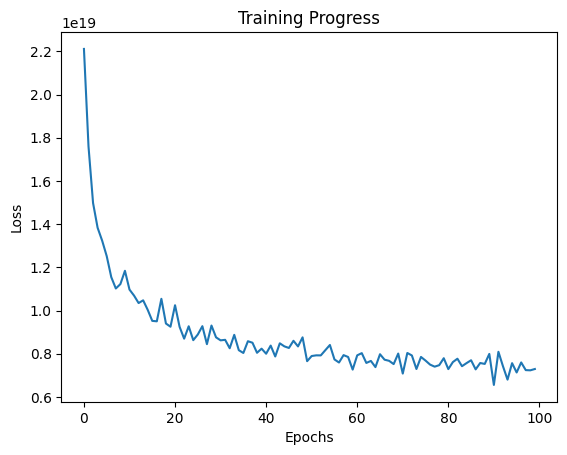

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


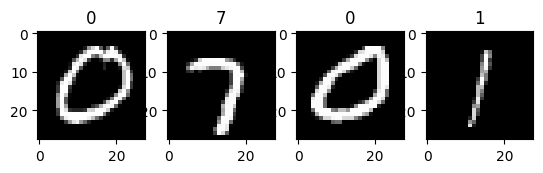

In [19]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from tqdm.notebook import tqdm_notebook
import random
from sklearn.preprocessing import OneHotEncoder


# Set up the training dataset with MNIST, download if not present, and apply the ToTensor transformation
train_dataset = MNIST("./data/", download=True, train=True, transform=ToTensor())

# Set up the test dataset with MNIST, download if not present, and apply the ToTensor transformation
test_dataset = MNIST("./data/", download=True, train=False, transform=ToTensor())

# Create DataLoader for training data with specified batch size and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=800, shuffle=True)

# Create DataLoader for test data with specified batch size and shuffle the data
test_loader = DataLoader(test_dataset, batch_size=800, shuffle=True)

# Set the number of training epochs
epochs = 100

# Set the threshold value for some specific purpose (not specified in the provided code)
threshold = 3.5

# Define the shape of the images in the dataset (1 channel, 28x28 pixels)
image_shape = (1, 28, 28)

# Calculate the flattened shape of the image
image_1d_shape = np.prod(image_shape)

# Define the architecture of the neural network with layers specifying the number of neurons in each layer
layers = [image_1d_shape, 500, 500, 500, 500]

# Specify which layers in the architecture are softmax layers
softmax_layers = [0, 1, 2, 3]
# The method for generating masks for negative data as proposed by Geoffrey Hinton in the article.

def negative_data_gen(batch):
    """
    Generate negative data by creating a hybrid image from two randomly selected images in the batch.

    Parameters:
    - batch (torch.Tensor): Input batch of images.

    Returns:
    - torch.Tensor: Hybrid image created from a combination of two randomly selected images.

    Note:
    The method involves selecting two random images from the batch and creating a hybrid image using a randomly
    generated binary mask. The mask is generated by convolving a randomly generated binary image with a blur filter.
    The final hybrid image is formed by combining parts of the two images based on the mask.

    """
    # Select the first image from the batch
    x1 = batch[0]

    # Shuffle the indices to select a random image from the batch
    permuted_indices = torch.randperm(batch.shape[0])

    # Get the number of rows in the batch
    num_rows = batch.shape[0]

    # Generate a random index
    random_index = torch.randint(0, num_rows, (1,)).item()

    # Get the randomly selected row
    x2 = batch[random_index]

    # Set the number of iterations for the random image generation
    random_iter = np.random.randint(5, 10)

    # Generate a random binary image
    random_image = np.random.randint(2, size=image_shape).squeeze().astype(np.float32)
    # Apply random iterations of blurring to the binary image
    for i in range(random_iter):
        random_image = convolve2d(random_image, np.array([[1/ 16, 1/8, 1/ 16], [1/8, 1/4, 1/8], [1/ 16, 1/8, 1/ 16]]) , mode='same', boundary='symm')

    # Create a hybrid image by combining parts of x1 and x2 based on the binary mask
    hybrid_image = x1.view(28, 28) * ((random_image > 0.5).astype(np.float32)) + \
                   x2.view(28, 28) * (1 - ((random_image > 0.5).astype(np.float32)))

    # Return the resulting hybrid image
    return hybrid_image


# Defining a custom layer that inherits from the nn.Linear module
# Defining a custom layer that inherits from the nn.Linear module
class Layer(nn.Linear):
    """
    Custom layer that extends nn.Linear. Initializes the layer with additional components.

    Parameters:
    - in_features (int): Number of input features.
    - out_features (int): Number of output features.
    - bias (bool): If True, adds a learnable bias to the output.
    - device (str or torch.device, optional): Device on which the layer will be stored.
    - dtype (torch.dtype, optional): Data type of the layer's parameters.

    Note: The layer includes a ReLU activation function, an Adam optimizer, and additional parameters for training.

    """
    def __init__(self, in_features, out_features, bias=True, device=None, dtype=None):
        # Calling the constructor of the parent class (nn.Linear)
        super().__init__(in_features, out_features, bias, device, dtype)

        # Initializing the ReLU activation function
        self.relu = nn.ReLU()

        # Initializing the Adam optimizer for the layer's parameters with a given learning rate
        self.optimizer = Adam(self.parameters(), lr=0.03)

        # Setting the threshold and number of epochs for training
        self.threshold = threshold
        self.epoch_num = epochs

    def train(self, x_pos, x_neg):
        # Performing training for a specified number of epochs
        for i in range(self.epoch_num):
            # Calculating the loss using a hinge loss formulation with threshold
            loss = torch.log(1 + torch.exp(torch.cat([threshold - self.relu(torch.mm(x_pos / (x_pos.norm(2, 1, keepdim=True) + 1e-4), self.weight.T) + self.bias.unsqueeze(0)).pow(2).mean(1), self.relu(torch.mm(x_neg / (x_neg.norm(2, 1, keepdim=True) + 1e-4), self.weight.T) + self.bias.unsqueeze(0)).pow(2).mean(1) - threshold]))).mean()

            # Zeroing the gradients of the optimizer
            self.optimizer.zero_grad()

            # Backpropagating the loss
            loss.backward()

            # Updating the optimizer's parameters
            self.optimizer.step()

        # Returning the ReLU activations of the positive and negative inputs after training
        return self.relu(torch.mm(x_pos / (x_pos.norm(2, 1, keepdim=True) + 1e-4), self.weight.T) + self.bias.unsqueeze(0)).detach(), self.relu(torch.mm(x_neg / (x_neg.norm(2, 1, keepdim=True) + 1e-4), self.weight.T) + self.bias.unsqueeze(0)).detach()

class Net(torch.nn.Module):
    """
    Neural network class for building and training multi-layer perceptrons.
    """

    def __init__(self, dims):
        super().__init__()
        self.layers = []  # List to store the layers of the neural network
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1]).cuda()]  # Adding layers to the network

    def predict(self, x, softmax_layers):
        """
        Predict the output of the neural network for the given input.

        Parameters:
        - x (torch.Tensor): Input tensor to the neural network.
        - softmax_layers (list): List of layer indices where softmax activation should be applied.

        Returns:
        - torch.Tensor: Concatenated output from selected softmax layers.
        """
        layers_output = torch.Tensor([]).cuda()
        tempLayer = x.clone()
        for i, layer in enumerate(self.layers):
            tempLayer = layer(tempLayer)
            if i in softmax_layers:
                layers_output = torch.cat([layers_output, tempLayer], 1)

        return layers_output

    def train(self, x_pos, x_neg):
        """
        Train the neural network with positive and negative examples.

        Parameters:
        - x_pos (torch.Tensor): Positive examples for training.
        - x_neg (torch.Tensor): Negative examples for training.
        - dims (list): List of dimensions representing the architecture of the network.

        Returns:
        None
        """
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)  # Training each layer of the network


model = Net( layers)
# Original code with refactoring
training_progress_bar = tqdm_notebook(iter(train_loader), leave=True)
for training_batch in training_progress_bar:
    positive_samples = training_batch[0]
    negative_samples = negative_data_gen(training_batch[0])
    # CUDA processing
    positive_samples, negative_samples = positive_samples.view(-1, image_1d_shape).cuda(), negative_samples.view(-1, image_1d_shape).cuda()
    # Model training
    model.train(positive_samples, negative_samples)


class LinearClassification(nn.Module):
    def __init__(self, input_dimension):
        # Initialize the LinearClassification module
        super().__init__()

        # Store the losses for each epoch
        self.epoch_losses = []

        # Define a linear layer with input_dimension input features and 10 output features
        self.linear = torch.nn.Linear(input_dimension, 10).cuda()

        # Set up the Stochastic Gradient Descent (SGD) optimizer with a specified learning rate
        self.optimizer = SGD(self.parameters(), lr=0.03)

        # Define the CrossEntropyLoss criterion for training
        self.criterion = nn.CrossEntropyLoss()

        # Define the Softmax activation function
        self.softmax = nn.Softmax()

    def predict(self, x):
        # Make a prediction using the model and apply the softmax activation
        return self.softmax(self.linear(model.predict(x.view(-1, image_1d_shape).cuda(), softmax_layers))).argmax()

    def train(self, data_loader, epoch_num):
        # Create a tqdm loop for visualizing the training progress
        linear_loop = tqdm_notebook(range(epoch_num), total=epoch_num)
        for i in linear_loop:
            batch_losses = []
            for batch in iter(data_loader):
                x, y = batch

                # Reshape y and perform one-hot encoding
                y = y.numpy().reshape(-1, 1)
                temp = OneHotEncoder().fit(np.arange(10).reshape((10, 1))).transform(y).toarray()

                # Calculate the loss using the defined criterion
                loss = self.criterion(self.linear(model.predict(x.view(-1, image_1d_shape).cuda(), softmax_layers)), torch.Tensor(temp).cuda())

                # Perform backpropagation, gradient descent, and update the weights
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                batch_losses.append(loss)

            # Calculate and store the average loss for the current epoch
            self.epoch_losses.append(float(sum(batch_losses) / len(batch_losses)))

            # Update the tqdm loop to display the current loss
            linear_loop.set_postfix(loss=self.epoch_losses[i])

    def test(self, data_loader):
        batch_losses = []
        for batch in iter(data_loader):
            x, y = batch
            # Reshape y and perform one-hot encoding
            y = y.numpy().reshape(-1, 1)
            temp = OneHotEncoder().fit(np.arange(10).reshape((10, 1))).transform(y).toarray()
            # Calculate the loss using the defined criterion
            loss = self.criterion(self.linear(model.predict(x.view(-1, image_1d_shape).cuda(), softmax_layers)), torch.Tensor(temp).cuda())
            batch_losses.append(loss)
        # Calculate and return the average test loss
        return float(sum(batch_losses) / len(batch_losses))


layers = layers[1:]
num = sum(layers[i] for i in softmax_layers)

linear_model = LinearClassification(num)
losses = linear_model.train(train_loader,epochs)
linear_model.test(test_loader)
plt.plot(linear_model.epoch_losses)
plt.title("Training Progress")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
# Get a batch of data from the test loader
batch = next(iter(test_loader))

# Create subplots
fig, ax1 = plt.subplots(1, 4)

# Loop through the batch and visualize predictions
for i in range(4):
    ax1[i].imshow(batch[0][i].squeeze(),cmap="gray")
    ax1[i].set_title(str(int(linear_model.predict(batch[0][i]))))
# Show the plot
plt.show()




In [20]:

# Calculate error of prediction and accuracy after training
error_count = 0
total_count = 0
accuracy1 = np.log10(linear_model.epoch_losses)/100
error_rate1 = 1 - accuracy1

# Loop through the test loader
for batch in iter(test_loader):
    x, y = batch

    # Make predictions
    predictions = [linear_model.predict(img) for img in x]

    # Convert predictions and y to PyTorch tensors if they are not already
    predictions = torch.tensor(predictions).cuda()
    y = y.cuda()

    # Calculate error count and total count
    error_count += torch.sum(predictions != y).item()
    total_count += len(y)

# Calculate accuracy
accuracy = 1 - error_count / total_count
error_rate = error_count / total_count

# Print or use the accuracy and error_rate as needed
print(f"Train Accuracy: {accuracy1[99]:.4f}")
print(f"Train Error Rate: {error_rate1[99]:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Error Rate: {error_rate:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules

Train Accuracy: 0.1886
Train Error Rate: 0.8114
Test Accuracy: 0.5372
Test Error Rate: 0.4628


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
